In [7]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import cv2

In [8]:
def load_imgs(vidPath, firstFrame, lastFrame):
    '''
    Reads frames from video and stores as a list
    
    Parameters: 
    vidPath (string): Path to video
    
    Returns: 
    list of images
    '''
    
    cap = cv2.VideoCapture(vidPath)
    length = np.arange(firstFrame, lastFrame)
    print(len(length)) 
    imgs = []
    for ff in length:
        cap.set(1,ff)
        ret, frame = cap.read()
        if np.mod(ff, 100) == 0:
            print(ff) # prints progress in 50 frames

            # convert to grey
            #img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        imgs.append(frame)
#         print("length of imgs: %s" % len(imgs))
            
    cap.release()
    return imgs

In [9]:
# adjust gamma, if your vid is too dark
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
 
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

In [10]:
# first = ['c-1_m13', 'c-2_m20','c-3_m10', 'c-10_m11']
first = ['c-10_m20']
direc = r'./dataFolders/PaperPipelineOutput/v3/OtherBodyParts/FirstVisit/' 

In [11]:
# use the list of final proboscis tracks as starting point to get the corresponding head and thorax data
visitnum = 0
path_for_visit_frames = r"../MothLearning/dataFolders/Output/Step5_FilesWith_TrueTrialAnd_ProboscisDetect_v2/"

#get path for videos
pathForVideo = r"G:\My Drive\Tom-Tanvi\Moth Learning Project\AllVideosForAnalysis\CompliedDataForAnalysis"
ourVideoPath = glob.glob(pathForVideo + "\**\\*.mp4", recursive = True)

In [12]:
# category = ['acute', 'obtuse']

711
48100
48200
48300
48400
48500
48600
48700


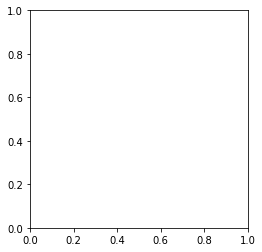

In [15]:
for mothID in first[0:1]:
    if not os.path.exists(direc + mothID + '_probHeadAngle.csv'):
        mothID = mothID + '_cropped'
    df = pd.read_csv(direc + mothID + '_ProbHeadAntennae.csv')
    df_angle = pd.read_csv(direc + mothID + '_probHeadAngle.csv')

#     proboscis = pd.read_csv(direc + mothID + '_proboscis_notCentered.csv')
#     headJoint = pd.read_csv(direc + mothID + '_HeadprobJoint_notCentered.csv')
#     mothCenter = pd.read_csv(direc + mothID + '_MothCOM_notCentered.csv')
    
    LfAntennae = df.loc[:, 'LAnt_x' : 'LAnt_y']
    RtAntennae = df.loc[:, 'RAnt_x': 'RAnt_y']
    head_dir = df.loc[:, 'head_dir_x':'head_dir_y']
    head = df.loc[:, 'head_x':'head_y']
    proboscis = df.loc[:, 'probocis_x':'probocis_y']

    tracks = [LfAntennae, RtAntennae, head_dir, head, proboscis]
    for tt in tracks:
        tt.columns = ['x', 'y']    
    
    path_frame_Reference = glob.glob(path_for_visit_frames + mothID + '_RawDataForExplorationTime.csv')
    Visit_info_f = pd.read_csv(path_frame_Reference[0])
    Visit_info = Visit_info_f[['MothIN', 'MothOut','ProboscisDetect']]

    fin = Visit_info.iloc[visitnum, 0]
    fout = Visit_info.iloc[visitnum, 2]
    if np.isnan(fout):
        fout = Visit_info.iloc[visitnum, 1]

    fin = int(fin)
    fout = int(fout)

    SpecificVideoPath = [f for f in ourVideoPath if mothID + '.mp4' in f][0]
    # load images
    imList = load_imgs(SpecificVideoPath, fin, fout)
    
#     for cat in category:
        
#         if cat == 'obtuse':
#             subset = df[(df.ProbAngle > np.pi/2) | (df.ProbAngle < -np.pi/2)]
#         else:
#             subset = df[(df.ProbAngle < np.pi/2) | (df.ProbAngle > -np.pi/2)]
#         len(df), len(subset)
   
    # make directory to store images
    string = mothID + '_checkHeadDirection'
    tempImgDirectory = os.path.join(os.path.dirname(r"./dataFolders/PaperPipelineOutput/Figures/v3/OtherBodyPartTracks/VideoCheck/temp/"), string)
    if not os.path.exists(tempImgDirectory):
        os.mkdir(tempImgDirectory)

    fig = plt.figure()
    for idx in df.index:
        # adjust gamma
        image = adjust_gamma(imList[idx], 1.5)
        plt.imshow(image)

        prob = proboscis.x[idx], proboscis.y[idx]
        hJ = head.x[idx], head.y[idx]
        hdir = head_dir.x[idx], head_dir.y[idx]

        hJ2prob_x_values = [hJ[0], prob[0]]
        hJ2prob_y_values = [hJ[1], prob[1]]
        plt.plot(hJ2prob_x_values, hJ2prob_y_values, 'm')

        body_x_values = [hJ[0], hdir[0]]
        body_y_values = [hJ[1], hdir[1]]
        plt.plot(body_x_values, body_y_values, 'y')

        plt.plot(hJ[0], hJ[1], 'o', color = 'orange')
        plt.plot(hdir[0], hdir[1], 'o', color = 'green')

        aa = df_angle.ProbAngle[idx]*180/np.pi

        s = 'angle = %0.3f' %aa
    #     s = 'test'
        plt.text(400, 50, s, fontsize=12, c = 'white')

        plt.savefig(tempImgDirectory + '/' + str(idx).zfill(4) + '.png')
        plt.cla()